# TOTVS Data Challenge

#### Exploratory Data Analysis

Our dataset is the transaction information of many restaurant meals. In this notebook we'll try and find interesting descriptions and patterns in the data.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import pymongo
import pprint

%matplotlib inline

In [2]:
from connectionstring import connectionstring as cs
sample = pymongo.MongoClient(cs)['totvs']['sample']

In [4]:
# retrieving a random document and looking at each feature it has
doc = sample.aggregate(
   [{ '$sample': { 'size': 1 } }]
)

doc = list(doc)[0]

for k in doc.keys():
    if k != '_id':
        print('>', k, '\n')
        pprint.pprint(doc[k])
        print('\n--~--\n')

> complemento 

{'valorTotal': 110.48}

--~--

> dets 

[{'nItem': '1',
  'prod': {'indTot': '1',
           'qCom': 1.414,
           'uCom': 'KG',
           'vProd': 97.0,
           'vUnCom': 68.6,
           'xProd': 'BUFFET'}},
 {'nItem': '2',
  'prod': {'indTot': '1',
           'qCom': 1.0,
           'uCom': 'UN',
           'vProd': 4.5,
           'vUnCom': 4.5,
           'xProd': 'REFRIGERANTE'}},
 {'nItem': '3',
  'prod': {'indTot': '1',
           'qCom': 1.0,
           'uCom': 'UN',
           'vProd': 4.5,
           'vUnCom': 4.5,
           'xProd': 'REFRIGERANTE'}},
 {'nItem': '4',
  'prod': {'indTot': '1',
           'qCom': 1.0,
           'uCom': 'UN',
           'vProd': 4.5,
           'vUnCom': 4.5,
           'xProd': 'REFRIGERANTE'}}]

--~--

> emit 

{'cnpj': '01.234.567/0001-89',
 'enderEmit': {'fone': '1-650-933-4902',
               'uf': 'CA',
               'xBairro': '',
               'xLgr': '650 Castro St. unit 210',
               'xMun': 'Mounta

Initially, we'll investigate the time interval this dataset maintains, so we can start to grasp what can be further analysed.

In [5]:
grouping = {
    '$group': {
        '_id': None,
        'firstMeal': {'$min': '$ide.dhEmi'},
        'lastMeal': {'$max': '$ide.dhEmi'}
    }
}

q = sample.aggregate([
    grouping
]).next()

print('First meal: {}'.format(q['firstMeal']))
print('Last meal:  {}\n'.format(q['lastMeal']))

First meal: 2016-01-05 12:01:54
Last meal:  2016-01-23 14:56:35



We can see we have data from meals that happened during a few weeks of january in 2016. This is not a very long time series, but should be enought for us to detect a few patterns.

Next, let's see how the meals are distributed during the days in a simple count. For now, we'll not differetiate the day of the week nor will we look at the value of the meals, which will be done in the next steps.

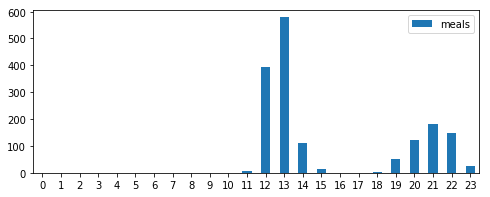

In [6]:
grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'meals': {'$sum': 1}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'meals': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

q = sample.aggregate([
    grouping,
    projecting,
    sorting
])

q = pd.DataFrame(list(q))
q.set_index('hour', drop=True, inplace=True)
q = pd.concat([pd.DataFrame(index=range(24)), q], axis=1).fillna(0).astype(int)

q.plot(kind='bar', rot=0, figsize=(8,3))

We can see that the meals concentrate around two different moments in the day, which is fully expected. To facilitate further comparisons between these two clusters, we'll create a new variable called _refeicao_, taking two possible values: _Almoco_ and _Jantar_.

In [7]:
vals = ['Almoco', 'Jantar']
updates = []

docs = sample.aggregate([{'$project': {'hour': {'$hour': '$ide.dhEmi'}}}])
for doc in docs:
    updates.append(pymongo.UpdateOne({'_id': doc['_id']}, {'$set': {'refeicao': vals[doc['hour'] > 16]}}))
u = sample.bulk_write(updates)
print('# modified docs: {}'.format(u.modified_count))

# modified docs: 1635


In [8]:
list(sample.aggregate([
    {
        '$group': {
            '_id': '$refeicao',
            'total': {'$sum': 1}
        }
    }
]))

[{'_id': 'Jantar', 'total': 530}, {'_id': 'Almoco', 'total': 1105}]

All docs nows have a _refeicao_ field and this counts make sense given our plot aboce, so it seems the operation was succesful.

Returning to the exploration of our dataset, let's examine the mean value of the meals, also by hour:

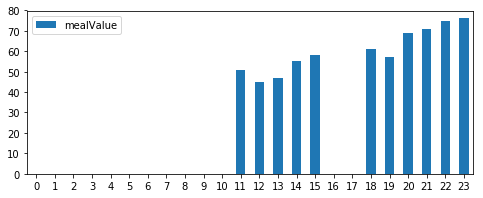

In [9]:
grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'mealValue': {'$avg': '$complemento.valorTotal'}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'mealValue': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

q = sample.aggregate([
    grouping,
    projecting,
    sorting
])

q = pd.DataFrame(list(q))
q.set_index('hour', drop=True, inplace=True)
q = pd.concat([pd.DataFrame(index=range(24)), q], axis=1).fillna(0).astype(int)

q.plot(kind='bar', rot=0, figsize=(8,3))

It seems that the later the bill is closed, the meal cost is expected to be higher. Let's now see only the actual meal cost, whithout beverage, which could be more commonly asked on dinner:

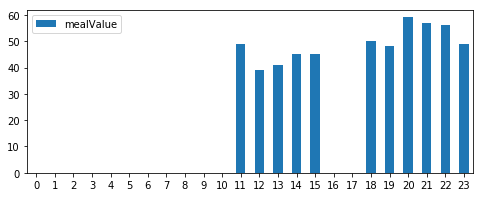

In [11]:
unwinding = {
    '$unwind': '$dets'
}

matching = {
    '$match': {
        'dets.prod.xProd': 'BUFFET'
    }
}

grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'mealValue': {'$avg': '$dets.prod.vProd'}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'mealValue': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

q = sample.aggregate([
    unwinding,
    matching,
    grouping,
    projecting,
    sorting
])

q = pd.DataFrame(list(q))
q.set_index('hour', drop=True, inplace=True)
q = pd.concat([pd.DataFrame(index=range(24)), q], axis=1).fillna(0).astype(int)

q.plot(kind='bar', rot=0, figsize=(8,3))

Even filtering the data to only consider the values of BUFFET, dinner seems more expensive.

In [ ]:
unwinding = {
    '$unwind': '$dets'
}

matching = {
    '$match': {
        'dets.prod.xProd': 'BUFFET'
    }
}

grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'mealValue': {'$avg': '$dets.prod.vUnCom'}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'mealValue': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

q = sample.aggregate([
    unwinding,
    matching,
    grouping,
    projecting,
    sorting
])

In [ ]:

grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'meals': {'$avg': '$complemento.valorTotal'}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'meals': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

a = sample.aggregate([
    grouping,
    projecting,
    sorting
])

pd.DataFrame(list(a))

In [19]:
# we'll add a new field to the data, making it simpler to filter by kind of meal ('Almoço' or 'Jantar')
docs = []
for doc in sample.aggregate([{'$project': {'data': '$ide.dhEmi', 'hora': {'$hour': '$ide.dhEmi'}}}]):
    print(doc)
    break

{'_id': ObjectId('5a96d219c873dee19ccc462a'), 'data': datetime.datetime(2016, 1, 5, 12, 3, 52), 'hora': 12}


We can see we have data regarding how much the meal cost, discriminated by the food and drinks. What we unfortunely do not have is customer information, as it could be very important for predicting amount spent for example.

Let's check some descriptive statistics of our dataset.

In [12]:
# valorTotal
sample.aggregate([
    {
        '$group': {
            '_id': None,
            'meanValue': {'$avg': '$complemento.valorTotal'},
            'stdDeviation': {'$stdDevPop': '$complemento.valorTotal'},
            'maxValue': {'$max': '$complemento.valorTotal'},
            'minValue': {'$min': '$complemento.valorTotal'}
        }
    },{
        '$project': {
            '_id': 0
        }
    }
]).next()

{'maxValue': 608.91,
 'meanValue': 55.50417125382263,
 'minValue': 9.74,
 'stdDeviation': 39.20546729763231}

In [14]:
# todos valores
v = sample.aggregate([
    {
        '$project': {
            '_id': 0,
            'valor': '$complemento.valorTotal',
            'timestamp': '$ide.dhEmi'
        }
    }
])

v = pd.DataFrame(list(v))
v

,timestamp,valor
0,2016-01-05 12:03:52,92.53
1,2016-01-05 12:01:54,24.90
2,2016-01-05 12:17:50,34.97
3,2016-01-05 12:18:35,46.23
4,2016-01-05 12:20:00,32.76
5,2016-01-05 12:22:16,57.11
6,2016-01-05 12:22:57,36.19
7,2016-01-05 12:23:25,32.37
8,2016-01-05 12:16:40,57.86
9,2016-01-05 12:35:11,34.17
